In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
dropout_value = 0.0
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(10), nn.Dropout(dropout_value)) 
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(15), nn.Dropout(dropout_value))
        self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), bias=False))
        self.pool1 = nn.MaxPool2d(2,2)
        
        
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels= 10, out_channels= 15, kernel_size=(3, 3), padding=1, bias=False), nn.ReLU(),nn.BatchNorm2d(15), nn.Dropout(dropout_value))
        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=15, out_channels= 18, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(18), nn.Dropout(dropout_value))
        self.convblock6 = nn.Sequential(nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), bias=False))
        self.pool2 = nn.MaxPool2d(2, 2)
        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels= 15, kernel_size=(3, 3), bias=False),nn.ReLU(),nn.BatchNorm2d(15), nn.Dropout(dropout_value))
        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=15, out_channels= 18, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(18), nn.Dropout(dropout_value))
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=5))
        self.convblock9 = nn.Sequential(nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), bias=False))
        
         

    def forward(self, x):
        x = self.convblock1(x) #input - 28; Output - 28; RF - 3; output channels - 10
        x = self.convblock2(x) #input - 28; Output - 28; RF - 5; output channels - 15
        x = self.convblock3(x)
        x = self.pool1(x) #input - 28; Output - 14; RF - 10; output channels - 15
        x = self.convblock4(x) #input - 14; Output - 14; RF - 12; output channels - 18
        x = self.convblock5(x)#input - 14; Output - 14; RF - 14; output channels - 10
        x = self.convblock6(x)
        x = self.pool2(x)#input - 7; Output - 7; RF - 28; output channels - 10
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)        
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [3]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 15, 28, 28]           1,350
              ReLU-6           [-1, 15, 28, 28]               0
       BatchNorm2d-7           [-1, 15, 28, 28]              30
           Dropout-8           [-1, 15, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             150
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 15, 14, 14]           1,350
             ReLU-12           [-1, 15, 14, 14]               0
      BatchNorm2d-13           [-1, 15, 14, 14]              30
          Dropout-14           [-1,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [5]:
torch.manual_seed(2)
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [6]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)
        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
        
        # Predict
        y_pred = model(data)
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Train_Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

        

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test_Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [7]:
from torch.optim.lr_scheduler import StepLR
torch.manual_seed(2)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=2.2863945960998535 batch_id=1 Train_Accuracy=6.25:   0%|          | 2/1875 [00:00<02:41, 11.59it/s]

EPOCH: 0


loss=0.04845257103443146 batch_id=1874 Train_Accuracy=92.36: 100%|██████████| 1875/1875 [02:28<00:00, 12.58it/s]
loss=0.07304017245769501 batch_id=1 Train_Accuracy=98.44:   0%|          | 2/1875 [00:00<02:21, 13.19it/s]


Test set: Average loss: 0.0533, Test_Accuracy: 9837/10000 (98.37%)

EPOCH: 1


loss=0.07476484775543213 batch_id=1874 Train_Accuracy=97.75: 100%|██████████| 1875/1875 [02:23<00:00, 13.04it/s]
loss=0.015860239043831825 batch_id=1 Train_Accuracy=100.00:   0%|          | 2/1875 [00:00<02:25, 12.91it/s]


Test set: Average loss: 0.0361, Test_Accuracy: 9891/10000 (98.91%)

EPOCH: 2


loss=0.004820868838578463 batch_id=1874 Train_Accuracy=98.24: 100%|██████████| 1875/1875 [02:23<00:00, 13.04it/s]
loss=0.2120373696088791 batch_id=1 Train_Accuracy=95.31:   0%|          | 2/1875 [00:00<02:32, 12.31it/s]


Test set: Average loss: 0.0312, Test_Accuracy: 9895/10000 (98.95%)

EPOCH: 3


loss=0.18919169902801514 batch_id=1874 Train_Accuracy=98.40: 100%|██████████| 1875/1875 [02:23<00:00, 13.05it/s]
loss=0.16456270217895508 batch_id=1 Train_Accuracy=96.88:   0%|          | 2/1875 [00:00<02:24, 12.96it/s]


Test set: Average loss: 0.0264, Test_Accuracy: 9914/10000 (99.14%)

EPOCH: 4


loss=0.016759298741817474 batch_id=1874 Train_Accuracy=98.85: 100%|██████████| 1875/1875 [02:23<00:00, 13.05it/s]
loss=0.0030734993051737547 batch_id=1 Train_Accuracy=100.00:   0%|          | 2/1875 [00:00<02:14, 13.94it/s]


Test set: Average loss: 0.0195, Test_Accuracy: 9932/10000 (99.32%)

EPOCH: 5


loss=0.03785490617156029 batch_id=1874 Train_Accuracy=98.91: 100%|██████████| 1875/1875 [02:22<00:00, 13.12it/s]
loss=0.06623046100139618 batch_id=1 Train_Accuracy=98.44:   0%|          | 2/1875 [00:00<02:14, 13.92it/s]


Test set: Average loss: 0.0194, Test_Accuracy: 9937/10000 (99.37%)

EPOCH: 6


loss=0.04616940766572952 batch_id=1874 Train_Accuracy=98.98: 100%|██████████| 1875/1875 [02:22<00:00, 13.12it/s]
loss=0.0014343246584758162 batch_id=1 Train_Accuracy=100.00:   0%|          | 2/1875 [00:00<02:19, 13.45it/s]


Test set: Average loss: 0.0183, Test_Accuracy: 9934/10000 (99.34%)

EPOCH: 7


loss=0.002079589758068323 batch_id=1874 Train_Accuracy=99.03: 100%|██████████| 1875/1875 [02:21<00:00, 13.23it/s]
loss=0.005053460132330656 batch_id=1 Train_Accuracy=98.44:   0%|          | 2/1875 [00:00<02:14, 13.94it/s]


Test set: Average loss: 0.0178, Test_Accuracy: 9935/10000 (99.35%)

EPOCH: 8


loss=0.1279531866312027 batch_id=1874 Train_Accuracy=99.06: 100%|██████████| 1875/1875 [02:21<00:00, 13.25it/s]
loss=0.004727277439087629 batch_id=1 Train_Accuracy=100.00:   0%|          | 2/1875 [00:00<02:23, 13.03it/s]


Test set: Average loss: 0.0184, Test_Accuracy: 9934/10000 (99.34%)

EPOCH: 9


loss=0.03972502797842026 batch_id=1874 Train_Accuracy=99.04: 100%|██████████| 1875/1875 [02:22<00:00, 13.18it/s]
loss=0.04792005196213722 batch_id=1 Train_Accuracy=100.00:   0%|          | 2/1875 [00:00<02:14, 13.88it/s]


Test set: Average loss: 0.0177, Test_Accuracy: 9941/10000 (99.41%)

EPOCH: 10


loss=0.023686110973358154 batch_id=1874 Train_Accuracy=99.11: 100%|██████████| 1875/1875 [02:23<00:00, 13.08it/s]
loss=0.004427817650139332 batch_id=1 Train_Accuracy=98.44:   0%|          | 2/1875 [00:00<02:13, 14.02it/s]


Test set: Average loss: 0.0177, Test_Accuracy: 9941/10000 (99.41%)

EPOCH: 11


loss=0.005670909769833088 batch_id=1874 Train_Accuracy=99.12: 100%|██████████| 1875/1875 [02:23<00:00, 13.10it/s]
loss=0.004393598064780235 batch_id=1 Train_Accuracy=100.00:   0%|          | 2/1875 [00:00<02:16, 13.72it/s]


Test set: Average loss: 0.0184, Test_Accuracy: 9938/10000 (99.38%)

EPOCH: 12


loss=0.007887526415288448 batch_id=1874 Train_Accuracy=99.09: 100%|██████████| 1875/1875 [02:22<00:00, 13.19it/s]
loss=0.003965870477259159 batch_id=1 Train_Accuracy=98.44:   0%|          | 2/1875 [00:00<02:25, 12.89it/s]


Test set: Average loss: 0.0172, Test_Accuracy: 9938/10000 (99.38%)

EPOCH: 13


loss=0.07420595735311508 batch_id=1874 Train_Accuracy=99.08: 100%|██████████| 1875/1875 [02:23<00:00, 13.07it/s]
loss=0.009540119208395481 batch_id=1 Train_Accuracy=100.00:   0%|          | 2/1875 [00:00<02:21, 13.28it/s]


Test set: Average loss: 0.0171, Test_Accuracy: 9939/10000 (99.39%)

EPOCH: 14


loss=0.00611830921843648 batch_id=1874 Train_Accuracy=99.09: 100%|██████████| 1875/1875 [02:24<00:00, 13.02it/s]



Test set: Average loss: 0.0173, Test_Accuracy: 9940/10000 (99.40%)



Text(0.5, 1.0, 'Test Accuracy')

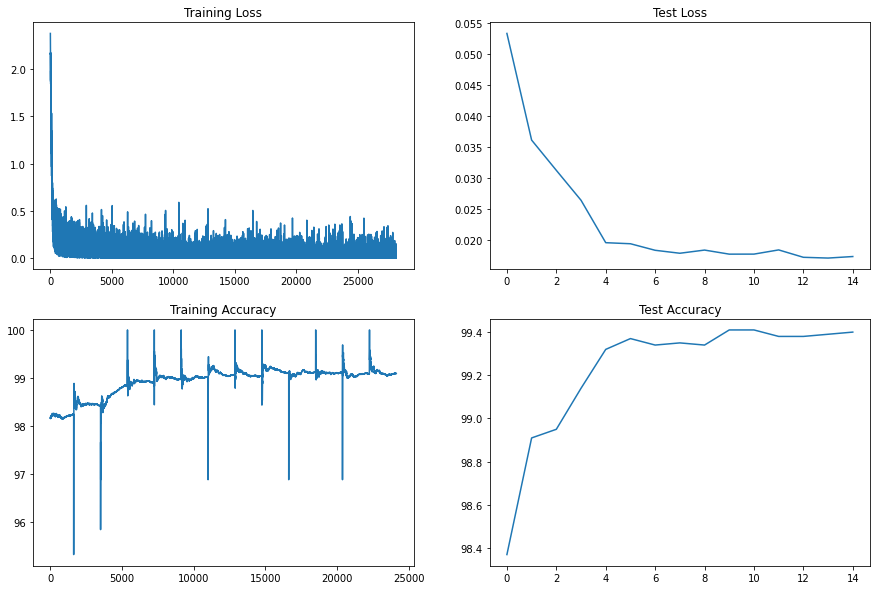

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")